In [1]:
# Implementing Shor's algorithm to factorize N = 15

In [1]:
# Initializing qubits
def initialize_qubits(given_circuit, n, m):    
    given_circuit.h(range(n)) # Hadamard gates on n-qubit counting register |x>
    given_circuit.x(n) # Initializing |w> register to eigenstate |1> ("1" is in decimal)

In [2]:
# Defining the controlled unitary U^x = a^x (mod N)
from qiskit import QuantumCircuit

def a_x_mod15(a, x):
    if a not in [2,4,7,8,11,13]: # all a's prime with N=15
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)  # creating U      
    for iteration in range(x):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate() # converting unitary U to a quantum gate
    U.name = f"{a}^{x} mod 15"
    c_U = U.control() # creating controlled-U
    return c_U

In [3]:
def modular_exponentiation(given_circuit, n, m, a):
    for x in range(n):
        exponent = 2**x
        given_circuit.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))

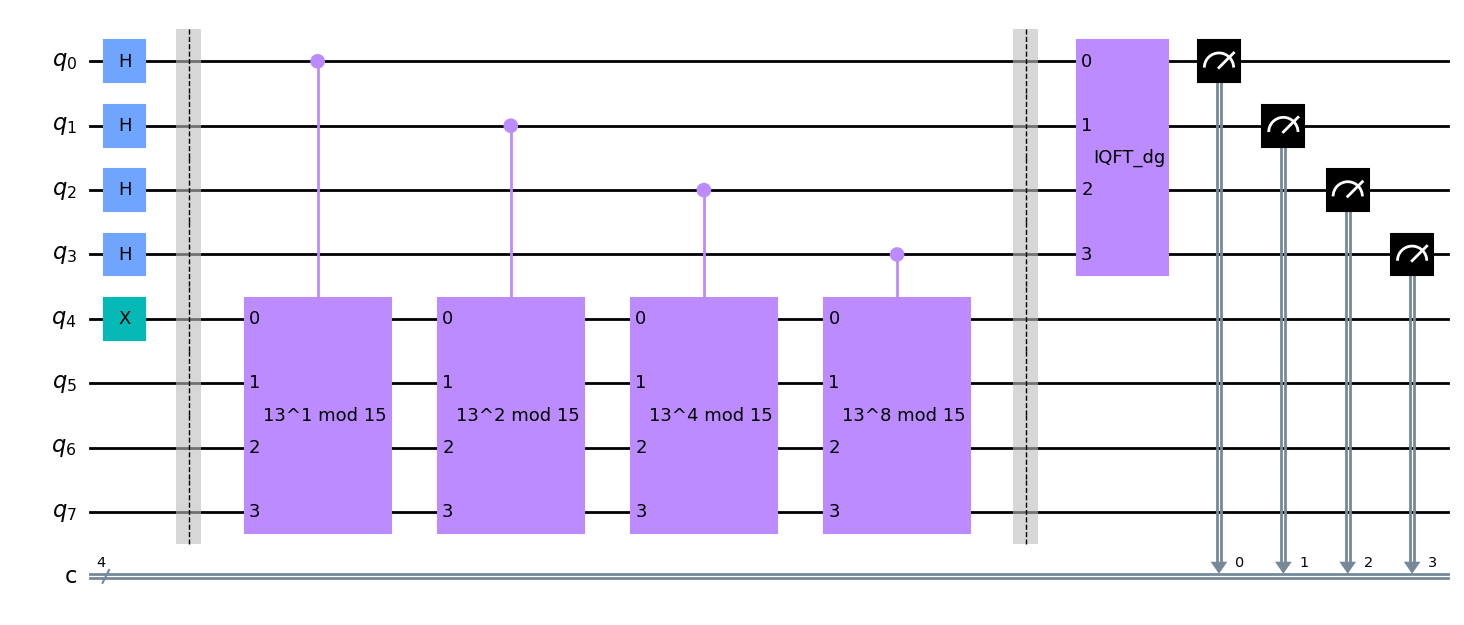

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

def shor_program(n, m, a):
    
    # set up quantum circuit
    shor = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(shor, n, m)
    shor.barrier()

    # apply modular exponentiation
    modular_exponentiation(shor, n, m, a)
    shor.barrier()

    # apply inverse QFT
    shor = shor.compose(QFT(n, inverse=True), range(n))

    # measure the first n qubits
    shor.measure(range(n), range(n))
    
    return shor
    
n = 4; m = 4; a = 13
mycircuit = shor_program(n, m, a)
mycircuit.draw()

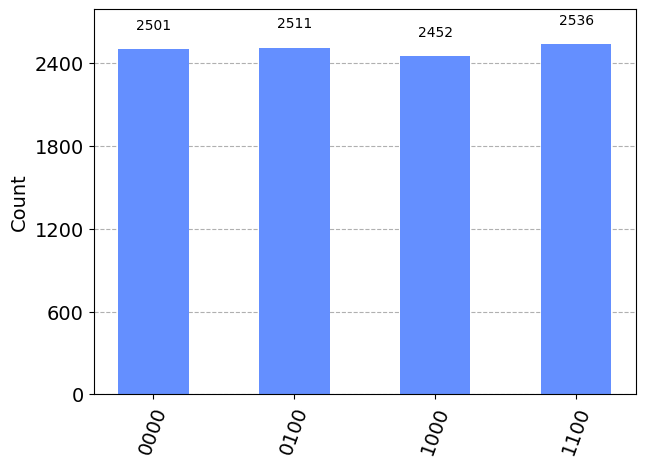

In [5]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=10000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [11]:
# CLassical post-processing part
import pandas as pd

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert binary string to decimal
    phase = decimal/(2**n)  # Phase = measurement / 2^n
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal}(dec)", f"{decimal}/{2**n} = {phase:.2f}"])
# Print the rows in a table
headers=["|x> Register Output", "Phase"]
table = pd.DataFrame(rows, columns=headers)
print(table)

   |x> Register Output         Phase
0   0000(bin) = 0(dec)   0/16 = 0.00
1   0100(bin) = 4(dec)   4/16 = 0.25
2  1100(bin) = 12(dec)  12/16 = 0.75
3   1000(bin) = 8(dec)   8/16 = 0.50


In [11]:
# We get the phase in float-type output. We will now use continued fractions to find "r".
# Python has a built-in "fractions" module to turn a float into a Fraction object, for example:

In [12]:
from fractions import Fraction
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [13]:
# As we can see, it returns fractions that return the result exactly (in this case, 0.6660000...)
# We can use the .limit_denominator() function to get an approximate fraction, with denominator below a certain value

In [14]:
# Get fraction nearest to 0.666 with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [15]:
# Since order "r" must be less than N = 15, so we will set the maximum denominator to be 15.

In [18]:
# Applying continued fractions to find "r" from the phase
from fractions import Fraction

rows, r_values = [], []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    r_values.append(frac.denominator)
    # Add these values to the rows in our table:
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers = ["Phase", "Fraction(t/r)", "Guess for r"]
table = pd.DataFrame(rows, columns=headers)
print(table)

   Phase Fraction(t/r)  Guess for r
0   0.00           0/1            1
1   0.25           1/4            4
2   0.75           3/4            4
3   0.50           1/2            2


In [19]:
# We got the correct result r = 4 with 50% success rate. 
# The bad results are because either t = 0, or because t and r are not coprime and instead of r we get a factor of r.
# Solution to this is to repeat the experiment until we get a satisfying result for r.

In [22]:
# Finding factors p,q from r by Shor's Algorithm
from math import gcd
import numpy as np

rows = []
for r in r_values:
    if r % 2 != 0: # If r is odd, algorithm fails
        print("Failed. Measured value is not an even number")
        continue
    x = int((a**(r/2)) % 15) # Define x = a^{r/2} (mod N)
    if (x + 1) % 15 == 0: # If x+1 (mod N) = 0, algorithm fails
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, 15), gcd(x - 1, 15)
    # Add these values to the rows in our table:
    rows.append([r, guesses])
# Print as a table
headers = ["Value of r", "Guess for (p,q)"]
table = pd.DataFrame(rows, columns=headers)
print(table)

Failed. Measured value is not an even number
   Value of r Guess for (p,q)
0           4          (5, 3)
1           4          (5, 3)
2           2          (1, 3)


In [23]:
# As we see, the algorithm failed once (for r=1), guessed (p,q) correctly twice (for r=4) and partially guessed one of the factors once (for r=2)
# So, with atleast 50% success rate, we got the factors 3 and 5.

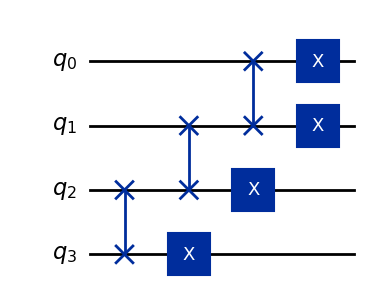

In [8]:
# Visualizing circuit for U^x = a^x (mod N)

from qiskit import QuantumCircuit
a = 13
x = 1 # put different value for different exponentiation U^x
U = QuantumCircuit(4)    
for iteration in range(x):
    if a in [2,13]:
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
    if a in [7,8]:
        U.swap(0,1)
        U.swap(1,2)
        U.swap(2,3)
    if a in [4, 11]:
        U.swap(1,3)
        U.swap(0,2)
    if a in [7,11,13]:
        for q in range(4):
            U.x(q)
U.draw()

In [5]:
# U |w> = |w.a (mod N)>
# w=1 i.e. |w> = |0001>, and a=13, N=15 i.e. |w.a (mod N)> = |13 (mod 15)> = |13> = |1101>
# So, U |0001> = |1101>. This is exactly what the above circuit does